In [426]:
import cv2
import dlib
import imutils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
import random
from scipy.optimize import linear_sum_assignment
from scipy.spatial import procrustes
from scipy.spatial.distance import euclidean


In [427]:
image_path1 = 'human_picture//000010.jpg'

In [428]:
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def shape_to_np(shape, image_height, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        x = shape.part(i).x
        y = image_height - shape.part(i).y 
        coords[i] = (x, y)
    return coords

def extract_facial_landmarks(image_path, shape_predictor):
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=500)
    image_height = image.shape[0] 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    shapes = []
    for rect in rects:
        shape = predictor(gray, rect)
        shape = shape_to_np(shape, image_height)  
        shapes.append(shape)
    return image, shapes


def extract_all_non_white_points(image_path, num_points=68):
    with Image.open(image_path) as img:
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = np.array(img)

        img = imutils.resize(img, width=500)
        pixels = np.array(img)

    white_threshold = 245
    non_white_pixels = np.where(np.any(pixels < white_threshold, axis=-1))
    non_white_point_coordinates = list(zip(non_white_pixels[1], non_white_pixels[0]))

    if len(non_white_point_coordinates) < num_points:
        raise ValueError("Not enough non-white points to sample the desired number of points.")
    sampled_points = random.sample(non_white_point_coordinates, num_points)

    return sampled_points

In [429]:
detector = dlib.get_frontal_face_detector()
shape_predictor = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(shape_predictor)
image1, shapes1 = extract_facial_landmarks(image_path1, shape_predictor)

In [430]:
def transform_points(points, x_range, y_range):
    min_x, max_x = x_range
    min_y, max_y = y_range
    
    orig_min_x = min(points, key=lambda p: p[0])[0]
    orig_max_x = max(points, key=lambda p: p[0])[0]
    orig_min_y = min(points, key=lambda p: p[1])[1]
    orig_max_y = max(points, key=lambda p: p[1])[1]

    transformed_points = []
    for x, y in points:
        new_x = min_x + (x - orig_min_x) / (orig_max_x - orig_min_x) * (max_x - min_x)
        new_y = min_y + (y - orig_min_y) / (orig_max_y - orig_min_y) * (max_y - min_y)
        transformed_points.append((new_x, new_y))

    return transformed_points

In [431]:
def calculate_euclidean_distance(shapes1, shapes2):
    distances = []
    for point1 in shapes1:
        min_distance = min(np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) for point2 in shapes2)
        distances.append(min_distance)
    return np.mean(distances)

In [432]:
def calculate_min_max_avg_distance(shapes1, shapes2):
    all_distances = []
    for point1 in shapes1:
        distances = [np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) for point2 in shapes2]
        all_distances.append(min(distances))

    return np.min(all_distances), np.max(all_distances), np.mean(all_distances)

In [433]:
def calculate_density(shapes1, shapes2, radius=250):
    density_list = []
    for point1 in shapes1:
        count = sum(np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) < radius for point2 in shapes2)
        density_list.append(count)
    return density_list

In [434]:
def calculate_knn_distance(shapes1, shapes2, k=100):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(shapes2)

    distances, _ = neigh.kneighbors(shapes1)

    return np.mean(distances)

In [435]:
def EMD(shapes1, shapes2):
    cost_matrix = np.zeros((len(shapes1), len(shapes2)))
    for i, coord1 in enumerate(shapes1):
        for j, coord2 in enumerate(shapes2):
            cost_matrix[i, j] = np.linalg.norm(np.array(coord1) - np.array(coord2))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_distance = cost_matrix[row_ind, col_ind].sum()
    max_distance = np.max(cost_matrix) * len(shapes1)
    similarity = 100 - (total_distance / max_distance * 100)

    return similarity

In [436]:
def calculate_jaccard_similarity(shapes1, shapes2, threshold):
    similar_pairs = 0
    for point1 in shapes1:
        if any(np.linalg.norm(np.array(point1) - np.array(point2)) < threshold for point2 in shapes2):
            similar_pairs += 1
    for point2 in shapes2:
        if any(np.linalg.norm(np.array(point2) - np.array(point1)) < threshold for point1 in shapes1):
            similar_pairs += 1
    similar_pairs = similar_pairs / 2
    union_size = len(shapes1) + len(shapes2) - similar_pairs
    jaccard_similarity = (similar_pairs / union_size) * 100

    return jaccard_similarity

In [437]:
def calculate_procrustes_similarity(shapes1, shapes2):
    mtx1 = np.array(shapes1)
    mtx2 = np.array(shapes2)
    mtx1_transformed, mtx2_transformed, disparity = procrustes(mtx1, mtx2)
    similarity_score = 1 / (1 + disparity)
    similarity_score_normalized = similarity_score * 100
    similarity_score_normalized = max(min(similarity_score_normalized, 100), 0)
    
    return similarity_score_normalized
    

In [438]:
def perform_comparisons(shapes1, shapes2, weights, max_values):
    euclidean_distance = calculate_euclidean_distance(shapes1, shapes2)
    min_distance, max_distance, avg_distance = calculate_min_max_avg_distance(shapes1, shapes2)
    density = calculate_density(shapes1, shapes2)
    knn_distance = calculate_knn_distance(shapes1, shapes2, k=50)
    emd = EMD(shapes1,shapes2)
    jaccard = calculate_jaccard_similarity(shapes1, shapes2,threshold = 42.5)
    procrustes = calculate_procrustes_similarity(shapes1, shapes2)
    
    euclidean_score = max(0, min(100, (max_values['euclidean'] - euclidean_distance) / max_values['euclidean'] * 100))
    min_max_avg_score = max(0, min(100, (max_values['min_max_avg'] - avg_distance) / max_values['min_max_avg'] * 100))
    density_score = max(0, min(100, np.mean(density) / max_values['density'] * 100))
    knn_score = max(0, min(100, (max_values['knn'] - knn_distance) / max_values['knn'] * 100))


    weighted_average_score = (
        weights["euclidean"] * euclidean_score +
        weights["min_max_avg"] * min_max_avg_score +
        weights["density"] * density_score +
        weights["knn"] * knn_score + 
        weights["EMD"] * emd + 
        weights["jaccard"] * jaccard +
        weights["procrustes"] * procrustes 
    )

    return weighted_average_score

In [439]:
weights = {
    "euclidean": 0,
    "min_max_avg": 0,
    "density": 0,
    "knn": 0,
    "Kuhn-Munkres": 0,
    "EMD": 0,
    "jaccard": 0,
    "procrustes": 1.75,
}

max_values = {
    "euclidean": np.sqrt((400 - 150) ** 2 + (300 - 50) ** 2),
    "min_max_avg": np.sqrt((400 - 150) ** 2 + (300 - 50) ** 2),
    "density": 68,  
    "knn": 1700, 
    
}

In [440]:
def process_folder(folder_path, shapes1, weights, max_values):
    scores = {}
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        shapes2 = extract_all_non_white_points(image_path)
        x_range = (150, 400)
        y_range = (50, 300)
        shapes1_new = transform_points(shapes1[0], x_range, y_range)
        shapes2_new = transform_points(shapes2, x_range, y_range)
        score = perform_comparisons(shapes1_new, shapes2_new, weights, max_values)
        scores[image_file] = score
        print(f"Score for {image_file}: {score:.2f}") 
    return scores

folder_path = 'images'  
scores = process_folder(folder_path, shapes1, weights, max_values)
highest_score_image = max(scores, key=scores.get)
highest_score_image_path = os.path.join(folder_path, highest_score_image)

Score for 1.jpg: 87.77
Score for 10.jpg: 88.39
Score for 100.jpg: 88.25
Score for 101.jpg: 88.20
Score for 102.jpg: 88.99
Score for 103.jpg: 87.91
Score for 104.jpg: 89.46
Score for 105.jpg: 88.08
Score for 106.jpg: 90.69
Score for 107.jpg: 88.06
Score for 108.jpg: 87.71
Score for 109.jpg: 88.09
Score for 11.jpg: 89.88
Score for 110.jpg: 88.54
Score for 12.png: 88.79
Score for 13.png: 88.26
Score for 14.jpg: 88.68
Score for 15.png: 87.84
Score for 16.jpg: 88.15
Score for 17.jpg: 88.47
Score for 18.png: 87.96
Score for 19.jpg: 88.06
Score for 2.jpg: 88.73
Score for 20.jpg: 88.03
Score for 21.jpg: 89.32
Score for 22.jpg: 87.92
Score for 23.jpg: 87.73
Score for 24.jpg: 87.62
Score for 25.jpg: 88.58
Score for 26.jpg: 87.86
Score for 27.jpg: 87.69
Score for 28.jpg: 88.22
Score for 29.jpg: 87.92
Score for 3.jpg: 88.20
Score for 30.jpg: 88.13
Score for 31.jpg: 87.97
Score for 32.jpg: 88.20
Score for 33.jpg: 88.85
Score for 34.jpg: 87.88
Score for 35.jpg: 88.59
Score for 36.jpg: 88.88
Score fo

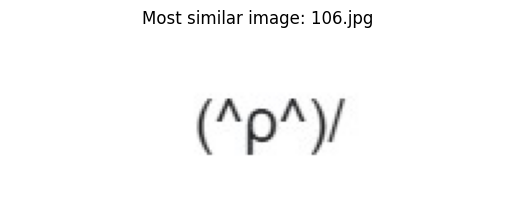

In [441]:
img = Image.open(highest_score_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Most similar image: {highest_score_image}")
plt.show()